<a href="https://colab.research.google.com/github/alanwuha/ce7455-nlp/blob/master/assignment-2/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE7455 Assignment 2

Student name: `Tan Lai Chian Alan`

Matric no: `G1902299C`

The structure of this notebook is as follow:
1. `Setup`: contains all the helper codes from the given codebase (probably don't need to view this section for grading)
2. `Experiments`: contains the codes and results of all the models trained on different configurations based on the assignment questions from parts (iv) to (viii)
3. `Summary of results`: Results of experiments presented in table format plus some write up

# 1. SETUP

##### Download the dataset

In [0]:
!rm -rf data
!mkdir data
!wget -P ./data https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.testa
!wget -P ./data https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.testb
!wget -P ./data https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.train
!wget -P ./data https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.train54019
!wget -P ./data https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/mapping.pkl
!wget -P ./data http://nlp.stanford.edu/data/glove.6B.zip
!unzip ./data/glove.6B.zip -d ./data

--2020-03-05 12:24:35--  https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827009 (808K) [text/plain]
Saving to: ‘./data/eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.01s   

2020-03-05 12:24:35 (79.4 MB/s) - ‘./data/eng.testa’ saved [827009/827009]

--2020-03-05 12:24:40--  https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/eng.testb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748094 (731K) [

##### Import libraries

In [0]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
plt.style.use('seaborn-pastel')

import os
import sys
import codecs
import re
import numpy as np

##### Define constants and paramaters

In [0]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "./data/eng.train" #Path to train file
parameters['dev'] = "./data/eng.testa" #Path to test file
parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 100 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "./data/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
parameters['name'] = "self-trained-model" # Model name
parameters['gradient_clip']=5.0
parameters['char_mode']="CNN"
parameters['encoder_mode']="LSTM"
models_path = "./models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = "./models/self-trained-model"

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [0]:
#paths to files 
#To stored mapping file
mapping_file = './data/mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

##### Load data and preprocess

In [0]:
def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

def load_sentences(path, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

In [0]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])

##### Update tagging scheme

In [0]:
def iob2(tags):
    """
    Check that tags have a valid BIO format.
    Tags in BIO1 format are converted to BIO2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    the function is used to convert
    BIO -> BIOES tagging
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    """
    Check and update sentences tagging scheme to BIO2
    Only BIO1 and BIO2 schemes are accepted for input data.
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Wrong tagging scheme!')

In [0]:
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(dev_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

In [120]:
print(train_sentences[0])
print(dev_sentences[0])
print(test_sentences[0])

[['EU', 'NNP', 'I-NP', 'S-ORG'], ['rejects', 'VBZ', 'I-VP', 'O'], ['German', 'JJ', 'I-NP', 'S-MISC'], ['call', 'NN', 'I-NP', 'O'], ['to', 'TO', 'I-VP', 'O'], ['boycott', 'VB', 'I-VP', 'O'], ['British', 'JJ', 'I-NP', 'S-MISC'], ['lamb', 'NN', 'I-NP', 'O'], ['.', '.', 'O', 'O']]
[['CRICKET', 'NNP', 'I-NP', 'O'], ['-', ':', 'O', 'O'], ['LEICESTERSHIRE', 'NNP', 'I-NP', 'S-ORG'], ['TAKE', 'NNP', 'I-NP', 'O'], ['OVER', 'IN', 'I-PP', 'O'], ['AT', 'NNP', 'I-NP', 'O'], ['TOP', 'NNP', 'I-NP', 'O'], ['AFTER', 'NNP', 'I-NP', 'O'], ['INNINGS', 'NNP', 'I-NP', 'O'], ['VICTORY', 'NN', 'I-NP', 'O'], ['.', '.', 'O', 'O']]
[['SOCCER', 'NN', 'I-NP', 'O'], ['-', ':', 'O', 'O'], ['JAPAN', 'NNP', 'I-NP', 'S-LOC'], ['GET', 'VB', 'I-VP', 'O'], ['LUCKY', 'NNP', 'I-NP', 'O'], ['WIN', 'NNP', 'I-NP', 'O'], [',', ',', 'O', 'O'], ['CHINA', 'NNP', 'I-NP', 'S-PER'], ['IN', 'IN', 'I-PP', 'O'], ['SURPRISE', 'DT', 'I-NP', 'O'], ['DEFEAT', 'NN', 'I-NP', 'O'], ['.', '.', 'O', 'O']]


##### Create Mappings for Words, Characters and Tags

In [0]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [122]:
dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 17493 unique words (203621 in total)
Found 75 unique characters
Found 19 unique named entity tags


##### Preparing final dataset

In [0]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [124]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
dev_data = prepare_dataset(
    dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
print("{} / {} / {} sentences in train / dev / test.".format(len(train_data), len(dev_data), len(test_data)))

14041 / 3250 / 3453 sentences in train / dev / test.


##### Load Word Embeddings

In [125]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


##### Storing Processed Data for Reuse

In [126]:
with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

word_to_id:  17493


### Model


##### Initialization of weights

In [0]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform(input_embedding, -bias, bias)

##### Initialization of linear layer

In [0]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

Initialization LSTM layer

In [0]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

#### Evaluation schemes: Forward pass and Viterbi algorithm

##### Helper Functions

In [0]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.view(-1).data.tolist()[0]

In [0]:
def score_sentences(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

##### Implementation of Forward Algorithm

In [0]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm explained above
    '''
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

##### Implementation of Viterbi Algorithm

In [0]:
def viterbi_algo(self, feats):
    '''
    In this function, we implement the viterbi algorithm explained above.
    A Dynamic programming based approach to find the best tag sequence
    '''
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

In [0]:
def forward_calc(self, sentence, chars, chars2_length, d):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    if self.encoder_mode == 'LSTM':
      feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    else:
      feats = self._get_cnn_features(sentence, chars, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

### Details of the Model

##### Main Model Implementation

The get_lstm_features function returns the LSTM's tag vectors. The function performs all the steps mentioned above for the model.

Steps:
1. It takes in characters, converts them to embeddings using our character CNN.
2. We concat Character Embeeding with glove vectors, use this as features that we feed to Bidirectional-LSTM. 
3. The Bidirectional-LSTM generates outputs based on these set of features.
4. The output are passed through a linear layer to convert to tag space.

In [0]:
def get_lstm_features(self, sentence, chars2, chars2_length, d):
    
    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

        ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)

    ## Word lstm
    ## Takes words as input and generates a output at each step
    lstm_out, _ = self.lstm(embeds)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)

    print(f'lstm_feats size: {lstm_feats.size()}')
    
    return lstm_feats

##### Function for Negative log likelihood calculation

In [0]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    # print(f'sentence: {sentence}')
    # print(f'tags: {tags}')

    if self.encoder_mode == 'LSTM':
      feats = self._get_lstm_features(sentence, chars2, chars2_length, d)
    else:
      feats = self._get_cnn_features(sentence, chars2, chars2_length, d)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

### Evaluation

##### Helper functions for evaluation

In [0]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [0]:
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a named entity
    default = tags["O"]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [0]:
def evaluating(model, datas, best_F,dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables

    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        
        if parameters['char_mode'] == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        
        if parameters['char_mode'] == 'CNN':
            d = {} 

            # Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))
        
        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val,out = model(dwords, chars2_mask, chars2_length, d)
        predicted_id = out  
        
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0
    new_acc = p

    print("{}: new_F: {} best_F: {} new_acc:{} ".format(dataset,new_F,best_F,p))
    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    
    if new_F>best_F:
        best_F=new_F
        # save=True

    return best_F, new_F, new_acc, save

##### Helper function for performing Learning rate decay

In [0]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

##### Helper function for performing early stopping

In [0]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        # if torch.isnan(metrics):
        if metrics is None:
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

# 2. EXPERIMENTS

### (iv) Replace the LSTM-based word-level encoder with a CNN layer (convolutional layer followed by an optional max pooling layer). The CNN layer should have the same output dimensions (out_channels) as the LSTM.

#### Get CNN Features Function

The get_cnn_features function returns the CNN's tag vectors. The function performs all the steps mentioned above for the model.

Steps:
1. It takes in characters, converts them to embeddings using our character CNN.
2. We concat Character Embedding with glove vectors, use this as features that we feed to CNN. 
3. The CNN generates outputs based on these set of features.
4. The output are passed through a linear layer to convert to tag space.

In [0]:
def get_cnn_features(self, sentence, chars2, chars2_length, d):

    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

    ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)
    embeds = embeds.unsqueeze(1).unsqueeze(1)
    # print(f'\nembeds: {embeds.size()}')

    ## Word lstm
    ## Takes words as input and generates an output
    cnn_out = self.conv1(embeds)
    # print(f'conv1: {cnn_out.size()}')

    ## Maxpool on the lstm output
    cnn_out = self.maxpool1(cnn_out)
    # print(f'maxpool1: {cnn_out.size()}')

    # 2-layer CNN word-level encoder
    if parameters['encoder_mode'] == 'CNN2':
      cnn_out = self.conv2(cnn_out)
      # print(f'conv2: {cnn_out.size()}')
      cnn_out = self.maxpool2(cnn_out)
      # print(f'maxpool2: {cnn_out.size()}')

    # 3-layer CNN word-level encoder
    if parameters['encoder_mode'] == 'CNN3':
      cnn_out = self.conv2(cnn_out)
      # print(f'conv2: {cnn_out.size()}')
      cnn_out = self.maxpool2(cnn_out)
      # print(f'maxpool2: {cnn_out.size()}')
      cnn_out = self.conv3(cnn_out)
      # print(f'conv3: {cnn_out.size()}')
      cnn_out = self.maxpool3(cnn_out)
      # print(f'maxpool3: {cnn_out.size()}')

    ## Reshaping the outputs from the cnn layer
    cnn_out = cnn_out.squeeze(-1).squeeze(-1)
    # print(f'cnn_out: {cnn_out.size()}')

    ## Linear layer converts the ouput vectors to tag space
    cnn_feats = self.hidden2tag(cnn_out)
    # print(f'cnn_feats: {cnn_feats.size()}')
    
    return cnn_feats

#### Model Class

In [0]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True, char_mode='CNN', encoder_mode='LSTM'):
        '''
        Input parameters:
                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU, 
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode
        self.encoder_mode = encoder_mode
        self.char_lstm = None

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            
            #Performing LSTM encoding on the character embeddings
            if self.char_mode == 'LSTM':
                self.char_lstm = nn.LSTM(char_embedding_dim, self.char_lstm_dim, num_layers=1, bidirectional=True)
                init_lstm(self.char_lstm)
                
            #Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])
        
        # Lstm Layer:
        if self.encoder_mode == 'LSTM':
          if self.char_mode == 'LSTM':
              self.lstm = nn.LSTM(embedding_dim+self.char_lstm_dim*2, hidden_dim, bidirectional=True)
          if self.char_mode == 'CNN':
              self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
          
          #Initializing the lstm layer using predefined function for initialization
          init_lstm(self.lstm)

          # Linear layer which maps the output of the bidirectional LSTM into tag space.
          self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # CNN (Single layer):
        if self.encoder_mode == 'CNN':
          # Conv layer
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))

          # Initializing the conv layer
          nn.init.xavier_uniform(self.conv1.weight)

          if self.char_mode == 'LSTM':
              print(f'embedding_dim={embedding_dim}, char_lstm_dim={self.char_lstm_dim*2}, in={embedding_dim+self.char_lstm_dim*2}')
              self.maxpool1 = nn.MaxPool2d((1, embedding_dim+self.char_lstm_dim*2))
          if self.char_mode == 'CNN':
              print(f'embedding_dim={embedding_dim}, self.out_channels={self.out_channels}, in={embedding_dim+self.out_channels}')
              self.maxpool1 = nn.MaxPool2d((1, embedding_dim+self.out_channels))

        # CNN (Two layer):
        if self.encoder_mode == 'CNN2':
          # Conv layer
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))
          self.conv2 = nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))

          # Initializing the conv layer
          nn.init.xavier_uniform(self.conv1.weight)
          nn.init.xavier_uniform(self.conv2.weight)

          self.maxpool1 = nn.MaxPool2d((1, 2))
          self.maxpool2 = nn.MaxPool2d((1, (embedding_dim+self.out_channels)//2))

        # CNN (Three layer):
        if self.encoder_mode == 'CNN3':
          # Conv layer
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))
          self.conv2 = nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))
          self.conv3 = nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0))

          # Initializing the conv layer
          nn.init.xavier_uniform(self.conv1.weight)
          nn.init.xavier_uniform(self.conv2.weight)
          nn.init.xavier_uniform(self.conv3.weight)

          self.maxpool1 = nn.MaxPool2d((1, 2))
          self.maxpool2 = nn.MaxPool2d((1, 2))
          self.maxpool3 = nn.MaxPool2d((1, (embedding_dim+self.out_channels)//4))

        # CNN (Three layer):
        if self.encoder_mode == 'CNNDILATED':
          # Conv layer
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0), dilation=1)
          self.conv2 = nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0), dilation=2)
          self.conv3 = nn.Conv2d(in_channels=hidden_dim*2, out_channels=hidden_dim*2, kernel_size=(1,1), padding=(0,0), dilation=3)

          # Initializing the conv layer
          nn.init.xavier_uniform(self.conv1.weight)
          nn.init.xavier_uniform(self.conv2.weight)
          nn.init.xavier_uniform(self.conv3.weight)

          self.maxpool1 = nn.MaxPool2d((1, 2))
          self.maxpool2 = nn.MaxPool2d((1, 2))
          self.maxpool3 = nn.MaxPool2d((1, (embedding_dim+self.out_channels)//4))

        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag)

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _get_cnn_features = get_cnn_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

#### Create and Train Model Function

In [0]:
def create_and_train_model():  
  # Create model
  model = BiLSTM_CRF(vocab_size=len(word_to_id),
                    tag_to_ix=tag_to_id,
                    embedding_dim=parameters['word_dim'],
                    hidden_dim=parameters['word_lstm_dim'],
                    use_gpu=use_gpu,
                    char_to_ix=char_to_id,
                    pre_word_embeds=word_embeds,
                    use_crf=parameters['crf'],
                    char_mode=parameters['char_mode'],
                    encoder_mode=parameters['encoder_mode'])
  
  # Enable GPU
  if use_gpu:
      model.cuda()

  print(f"\nChar mode: {parameters['char_mode']}, Encoder mode: {parameters['encoder_mode']}")

  # Training parameters
  learning_rate = 0.015
  momentum = 0.9
  number_of_epochs = parameters['epoch'] 
  decay_rate = 0.05
  gradient_clip = parameters['gradient_clip']
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # Variables which will used in training process
  losses = [] #list to store all losses
  loss = 0.0 #Loss Initializatoin
  best_dev_F = -1.0 # Current best F-1 Score on Dev Set
  best_test_F = -1.0 # Current best F-1 Score on Test Set
  best_train_F = -1.0 # Current best F-1 Score on Train Set
  all_F = [[0, 0, 0]] # List storing all the F-1 Scores
  all_acc = [[0, 0, 0]] # List storing all the Accuracy Scores
  eval_every = len(train_data) # Calculate F-1 Score after this many iterations
  plot_every = 2000 # Store loss after this many iterations
  count = 0 #Counts the number of iterations

  # Define early stopping
  es = EarlyStopping(patience=10)

  # eval_every = 1

  tr = time.time()
  model.train(True)
  for epoch in range(1,number_of_epochs):
      print(f'Epoch {epoch}:')
      for i, index in enumerate(np.random.permutation(len(train_data))):
      # for i, index in enumerate(np.random.permutation(eval_every)):
          count += 1
          data = train_data[index]

          ##gradient updates for each data entry
          model.zero_grad()

          sentence_in = data['words']
          sentence_in = Variable(torch.LongTensor(sentence_in))
          tags = data['tags']
          chars2 = data['chars']
          
          if parameters['char_mode'] == 'LSTM':
              chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
              d = {}
              for i, ci in enumerate(chars2):
                  for j, cj in enumerate(chars2_sorted):
                      if ci == cj and not j in d and not i in d.values():
                          d[j] = i
                          continue
              chars2_length = [len(c) for c in chars2_sorted]
              char_maxl = max(chars2_length)
              chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
              for i, c in enumerate(chars2_sorted):
                  chars2_mask[i, :chars2_length[i]] = c
              chars2_mask = Variable(torch.LongTensor(chars2_mask))
          
          if parameters['char_mode'] == 'CNN':

              d = {}

              ## Padding the each word to max word size of that sentence
              chars2_length = [len(c) for c in chars2]
              char_maxl = max(chars2_length)
              chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
              for i, c in enumerate(chars2):
                  chars2_mask[i, :chars2_length[i]] = c
              chars2_mask = Variable(torch.LongTensor(chars2_mask))


          targets = torch.LongTensor(tags)

          #we calculate the negative log-likelihood for the predicted tags using the predefined function
          if use_gpu:
              neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d)
          else:
              neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)

          loss += neg_log_likelihood.item() / len(data['words'])
          neg_log_likelihood.backward()

          #we use gradient clipping to avoid exploding gradients
          torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)
          optimizer.step()

          #Storing loss
          if count % plot_every == 0:
              loss /= plot_every
              print(count, ': ', loss)
              if losses == []:
                  losses.append(loss)
              losses.append(loss)
              loss = 0.0

          #Evaluating on Train, Test, Dev Sets
          if count % (eval_every) == 0 and count > (eval_every * 20) or count % (eval_every*4) == 0 and count < (eval_every * 20):
              print(f'Evaluating on Train, Test, Dev Sets at count={count}')
              model.train(False)
              best_train_F, new_train_F, new_train_acc, _ = evaluating(model, train_data, best_train_F,"Train")
              best_dev_F, new_dev_F, new_dev_acc, save = evaluating(model, dev_data, best_dev_F,"Dev")
              if save:
                  print("Saving Model to ", model_name)
                  torch.save(model.state_dict(), model_name)
              best_test_F, new_test_F, new_test_acc, _ = evaluating(model, test_data, best_test_F,"Test")

              all_F.append([new_train_F, new_dev_F, new_test_F])
              all_acc.append([new_train_acc, new_dev_acc, new_test_acc])

              model.train(True)

          #Performing decay on the learning rate
          if count % len(train_data) == 0:
              adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

      if es.step(all_acc[-1][1]):
        print(f'Early stopping: epoch={epoch}, count={count}, new_acc_F={all_acc[-1][1]}')
        break # early stopping criterion is met, we can stop now

  print(f'{(time.time() - tr) / 60} minutes')
  plt.plot(losses)
  plt.show()

  return all_F

### (v-1) Single-layer CNN word-level encoder + CNN for char-level encoder

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


embedding_dim=100, self.out_channels=25, in=125

Char mode: CNN, Encoder mode: CNN
Epoch 1:
2000 :  0.737165193793388
4000 :  0.4630021707351103
6000 :  0.3520884458198159
8000 :  0.32779226704624415
10000 :  0.26712157978336726
12000 :  0.2602964699875118
14000 :  0.2451460492784273
Epoch 2:
16000 :  0.20770525502604867
18000 :  0.21400625360285408
20000 :  0.2207958024092076
22000 :  0.18348525200881263
24000 :  0.2198747966141346
26000 :  0.20347223300284234
28000 :  0.1909624910289265
Epoch 3:
30000 :  0.17662747609123247
32000 :  0.15741750009548144
34000 :  0.17566715449708933
36000 :  0.19145278044725855
38000 :  0.16809951352666877
40000 :  0.16701481837352525
42000 :  0.14941544985611094
Epoch 4:
44000 :  0.15786564075957507
46000 :  0.15822640427483609
48000 :  0.14184765516437184
50000 :  0.15541013058022757
52000 :  0.15701896393209827
54000 :  0.14821809890750895
56000 :  0.14879201782955295
Evaluating on Train, Test, Dev Sets at count=56164
Train: new_F: 0.891801046674892

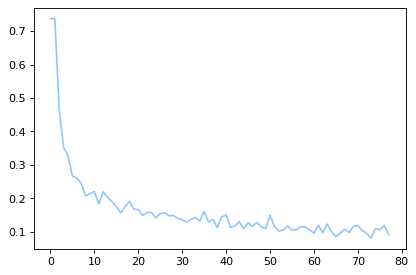

In [145]:
parameters['char_mode'] = "CNN"
parameters['encoder_mode'] = "CNN"
parameters['crf'] = 1

# 1-layer CNN word + CNN char
all_F_1_CNN = create_and_train_model()

In [152]:
all_F_1_CNN

[[0, 0, 0],
 [0.8918010466748925, 0.7724989707698642, 0.6836962112120692],
 [0.9042905692438403, 0.7648051426275614, 0.6774762664874401]]

### (v-2) Single-layer CNN word-level encoder + LSTM char-level encoder

In [0]:
parameters['char_mode'] = "LSTM"
parameters['encoder_mode'] = "CNN"
parameters['crf'] = 1

# 1-layer CNN word + LSTM char
all_F_1_LSTM = create_and_train_model()

### (vi-1) Multi-layer CNN word-level encoder + CNN char-level encoder

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Char mode: CNN, Encoder mode: CNN2
Epoch 1:
2000 :  0.8432320092154666
4000 :  0.41078950854042134
6000 :  0.35395080738528
8000 :  0.3489349178203394
10000 :  0.29658253415957103
12000 :  0.24435523652543242
14000 :  0.2622555948218334
Epoch 2:
16000 :  0.19324782228003967
18000 :  0.2027843482306702
20000 :  0.19349774641577436
22000 :  0.162736936646359
24000 :  0.16669259374158574
26000 :  0.1842432376822996
28000 :  0.1584044385656399
Epoch 3:
30000 :  0.13692251540901507
32000 :  0.12924765459478885
34000 :  0.14426873641742008
36000 :  0.13523990991950194
38000 :  0.13309088708727948
40000 :  0.12026281945516455
42000 :  0.11443571741553889
Epoch 4:
44000 :  0.11296360009067433
46000 :  0.10224831200463384
48000 :  0.11441114746636637
50000 :  0.10177052598900826
52000 :  0.11272703488834701
54000 :  0.1006185082549025
56000 :  0.11120206314369098
Evaluating on Train, Test, Dev Sets at count=56164
Train: new_F: 0.8759489339862713 best_F: -1.0 new_acc:0.8785603980782429 
Dev: ne

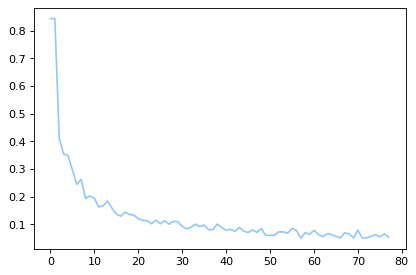

In [150]:
parameters['char_mode'] = "CNN"
parameters['crf'] = 1

# 2-layer CNN word + CNN char
parameters['encoder_mode'] = "CNN2"
all_F_2_CNN = create_and_train_model()

In [155]:
all_F_2_CNN

[[0, 0, 0],
 [0.8759489339862713, 0.7517955570402538, 0.6748242645144494],
 [0.933364859636301, 0.8173311978420298, 0.7427965352660422]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Char mode: CNN, Encoder mode: CNN3
Epoch 1:
2000 :  0.8869393050287014
4000 :  0.43040236447271474
6000 :  0.32768760109730166
8000 :  0.31997711557092245
10000 :  0.29506998437751897
12000 :  0.25814166540495653
14000 :  0.22424407182493653
Epoch 2:
16000 :  0.20954415709836752
18000 :  0.18623337671571852
20000 :  0.18740066617752418
22000 :  0.19039187687142714
24000 :  0.16076175590504255
26000 :  0.1657679704044715
28000 :  0.16115109758474444
Epoch 3:
30000 :  0.1204775774857185
32000 :  0.1302107527793812
34000 :  0.12966300109152856
36000 :  0.1190771500947573
38000 :  0.11380325309934541
40000 :  0.12538207244110328
42000 :  0.11908143326049735
Epoch 4:
44000 :  0.08132236441049463
46000 :  0.08649285505486559
48000 :  0.11754789617235592
50000 :  0.09308279145752246
52000 :  0.08905477569698864
54000 :  0.11592761179559938
56000 :  0.11389263607490485
Evaluating on Train, Test, Dev Sets at count=56164
Train: new_F: 0.9170569701098527 best_F: -1.0 new_acc:0.9156923600187067 


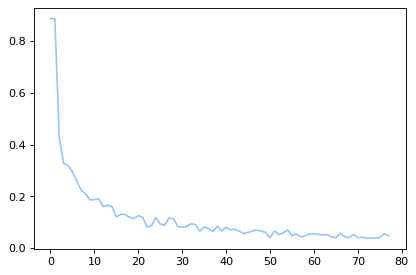

In [154]:
parameters['char_mode'] = "CNN"
parameters['crf'] = 1

# 3-layer CNN word + CNN char
parameters['encoder_mode'] = "CNN3"
all_F_3_CNN = create_and_train_model()

In [156]:
all_F_3_CNN

[[0, 0, 0],
 [0.9170569701098527, 0.8059625212947189, 0.7137828323855944],
 [0.9475402191653066, 0.8119891008174387, 0.722202166064982]]

### (vii) Replace the simple convolution layers in steps (iv-v) by dialated convolution layers. In particular, define a CNN with `3` dialated layers, where dialated factor varies from `1` (first layer) to `3` (third layer). Report the NER results with the newly implemented dialated layers (you do not need to change anything in the network).

In [0]:
parameters['char_mode'] = "CNN"
parameters['encoder_mode'] = "CNN_DILATED"
parameters['crf'] = 1

all_F_DILATED = create_and_train_model()

### (viii) Now, instead of using a CRF output layer, simply use a softmax output and report the results.

In [0]:
parameters['char_mode'] = "CNN"
parameters['encoder_mode'] = "CNN_DILATED"
parameters['crf'] = 0

all_F_DILATED = create_and_train_model()

### (ix) Please summarize your observations.

- Faster drop in `Loss` in Two-Layer CNN vs Single-Layer CNN (~0.1 loss vs ~0.2 loss at Epoch 2)

# 3. SUMMARY OF RESULTS

In [0]:
import pandas as pd

#### 1. `CNN char-level encoder` vs `LSTM char-level encoder` (both using `Single CNN word-level encoder`)

#### 2. `Single-layer CNN word-level encoder` vs `Multi-layer CNN word-level encoder` (all using `CNN char-level encoder`)

In [166]:
# Get all val scores of each model
val_cnn_1 = [f1[1] for f1 in all_F_1_CNN]
val_cnn_2 = [f1[1] for f1 in all_F_2_CNN]
val_cnn_3 = [f1[1] for f1 in all_F_3_CNN]

# Get best val score index of each model
best_val_cnn_1_index = val_cnn_1.index(max(val_cnn_1))
best_val_cnn_2_index = val_cnn_2.index(max(val_cnn_2))
best_val_cnn_3_index = val_cnn_3.index(max(val_cnn_3))

# Get test score w.r.t best validation score of each model
test_cnn_1 = all_F_1_CNN[best_val_cnn_1_index][2]
test_cnn_2 = all_F_2_CNN[best_val_cnn_2_index][2]
test_cnn_3 = all_F_3_CNN[best_val_cnn_3_index][2]

# Get best val score of each mode
val_cnn_1 = max(val_cnn_1)
val_cnn_2 = max(val_cnn_2)
val_cnn_3 = max(val_cnn_3)

# Construct results table
df = pd.DataFrame()
df['model'] = ['cnn_1', 'cnn_2', 'cnn_3']
df['val'] = [val_cnn_1, val_cnn_2, val_cnn_3]
df['test'] = [test_cnn_1, test_cnn_2, test_cnn_3]

df

,model,val,test
0,cnn_1,0.772499,0.683696
1,cnn_2,0.817331,0.742797
2,cnn_3,0.811989,0.722202


In [159]:
x = [1,2,3,4,5]
x.index(max(x))

4

#### 3. `Dilated 3-Layer CNN word-level encoder` with `CNN char-level encoder`

#### 4. `Dilated 3-Layer CNN word-level encoder` with `CNN char-level encoder` and `Softmax output layer`